In [18]:
import tensorflow as tf
import numpy as np
import os
import time
from keras import Sequential,layers
import pandas as pd
import io


In [2]:
a="hi@is!!be!"
print(a)

hi@is!!be!


In [3]:
print(repr(a))

'hi@is!!be!'


In [4]:
path = tf.keras.utils.get_file("shakespeare.txt", "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt")

1122304/1115394 [==============================] - 0s 0us/step


In [5]:
path[:50]

'/root/.keras/datasets/shakespeare.txt'

In [6]:
text = open(path, "rb").read().decode(encoding="utf-8")#utf-8 it is format which can understand any character
print("{}".format(len(text)))

1115394


In [7]:
vocab = sorted(set(text))#set is a function which return the unique characters from data
print(len(vocab))

65


In [8]:
char2id = {u:i for i, u in enumerate(vocab)}#giving the index to each unique character in data
id2char = np.array(vocab)#converting the unique characters to an array
text_as_int = np.array([char2id[c] for c in text])#giving the enumerate code to every charecter in the data

In [9]:
seq_len = 100 #considering sequence length as 100
examples = len(text)//(seq_len+1) 
#creating training examples
train_examples = tf.data.Dataset.from_tensor_slices(text_as_int)

#printing from training_examples
for i in train_examples.take(10):
  print(type(i.numpy()))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


In [10]:
#create batch examples
sequences = train_examples.batch(seq_len+1, drop_remainder=True)

for i in sequences.take(5):
  #print(repr(i))
  print(repr("".join(id2char[i])))
  

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [11]:
#create labels and features

def spli_input_target(example):
  features = example[:-1]
  target = example[1:]
  return features, target

dataset = sequences.map(spli_input_target)

#print the labels and features

for inp, out in dataset.take(1):
  print(repr("".join(id2char[inp])))
  print(repr("".join(id2char[out])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [12]:
Batch_size = 64
Buffer_size = 10000

#Each buffer size contains 100 batches and each batch size is 100 examples (example size is 101 characters)
#Shuffling batches

dataset = dataset.shuffle(Buffer_size).batch(Batch_size, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [13]:
vocab_size = len(vocab)
emdb_dimension = 256
rnn_units = 1024

In [14]:
def build_model(vocab_size, dimension, rnn_units, batch_size):
  model = Sequential()
  model.add(layers.Embedding(vocab_size, dimension,batch_input_shape = [batch_size, None]))
  model.add(layers.GRU(rnn_units, return_sequences=True, stateful=True,
                       recurrent_initializer='glorot_uniform'))
  model.add(layers.Dense(vocab_size))
  return model

In [15]:
model = build_model(vocab_size=len(vocab), dimension=emdb_dimension, rnn_units=rnn_units, batch_size=Batch_size)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           16640     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [19]:
for input_example, target_example in dataset.take(1):
  predictions = model(input_example)#predicting the values from 1st sequence input_example
  print(predictions[1])
  print(predictions.shape)

tf.Tensor(
[[-0.00343658 -0.01502991  0.0022298  ... -0.01276394  0.00417949
   0.00989324]
 [-0.00728888 -0.00395077 -0.00139369 ... -0.01101313  0.01504948
   0.00167927]
 [ 0.00326975  0.00152457  0.00484526 ... -0.00141118  0.01595432
  -0.00357935]
 ...
 [ 0.00576745 -0.01077473  0.00603027 ...  0.00398898 -0.01472734
  -0.0193965 ]
 [ 0.00919743 -0.00774173  0.00508142 ... -0.01038653 -0.00893181
  -0.00537622]
 [-0.00772071  0.00947932 -0.00831406 ... -0.00982952 -0.01028185
  -0.00449619]], shape=(100, 65), dtype=float32)
(64, 100, 65)


In [20]:
sample_indices = tf.random.categorical(predictions[0], num_samples=1)
sample_indices = tf.squeeze(sample_indices, axis = 1).numpy()

In [21]:
print("input: \n", repr("".join(id2char[input_example[0]])))
print("Next Character: \n", repr("".join(id2char[sample_indices])))

input: 
 'not where;\nTo lie in cold obstruction and to rot;\nThis sensible warm motion to become\nA kneaded clod'
Next Character: 
 '3kLfMukopcJq&b, USZq3tbVWgPhTjYfN$, $,$DHRF:zvfu.XUhuno\noDb-NwrLWKM3T:MGgkLqXRQweibyme&fOvhuccNeQpVF'


In [22]:
def loss(labels, logits):
   return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)#getting the loss function of the model

loss_example = loss(target_example, predictions)
print("prediction shape", predictions.shape)
print("scalar loss", loss_example.numpy().mean())#return the mean loss of the model

prediction shape (64, 100, 65)
scalar loss 4.1742067


In [23]:
model.compile(optimizer="adam", loss=loss)#compiling the model

In [24]:
#saving the weights of the model
checkpoint_dir = "./training_checkpoint"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)

In [25]:
EPOCHS = 5 #No. of epochs 

In [26]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])#fitting the model

Epoch 1/5
172/172 [==============================] - 12s 56ms/step - loss: 3.2100
Epoch 2/5
172/172 [==============================] - 11s 57ms/step - loss: 2.0536
Epoch 3/5
172/172 [==============================] - 11s 58ms/step - loss: 1.7459
Epoch 4/5
172/172 [==============================] - 11s 59ms/step - loss: 1.5723
Epoch 5/5
172/172 [==============================] - 12s 61ms/step - loss: 1.4690


In [27]:
summary = history.history

In [28]:
summary.keys()

dict_keys(['loss'])

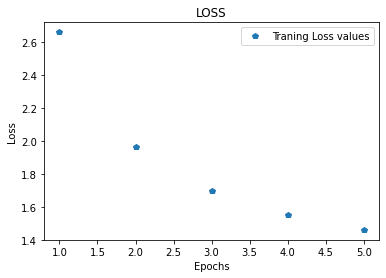

In [29]:
import matplotlib.pyplot as plt
loss = summary['loss']
epochs = range(1, 6)
plt.plot(epochs, loss, 'p', label = "Traning Loss values")
plt.title("LOSS")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [30]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoint/ckpt_5'

In [31]:
model = build_model(vocab_size, emdb_dimension, rnn_units, batch_size=1)

In [32]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))#loading the weights which saved in checkppint_dir
model.build(tf.TensorShape([1, None]))

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [34]:
input_eval = [12]
print(input_eval)
input_eval = tf.expand_dims(input_eval, 0)#here shape will be changed(previously-shape(1) now changed to (1, 1))
print(input_eval)
prediction = model(input_eval)#return the the 71 differnt character with there probabilty weights assigned
print(prediction)
prediction = tf.squeeze(prediction, 0)#squeeze the prediction values means it returns same values 
print(prediction)
predicted_id = tf.random.categorical(prediction, num_samples=1)[-1, 0].numpy()
print(predicted_id)#returns the highest probabilty weight from 71 different characters

[12]
tf.Tensor([[12]], shape=(1, 1), dtype=int32)
tf.Tensor(
[[[10.254849    8.201426    2.5477593   0.03419755 -0.81719214
    4.7891703   3.5829117   4.7018304   3.3419847   2.2931836
    3.7552383   3.2689984   3.5843463  -0.70510477  0.4054444
    0.2495133   0.15097906 -1.0598185   1.0429189   0.27328098
   -1.5206938  -0.19402343 -1.8989271  -2.754269   -0.1541318
   -0.9670357   3.246897    1.3802284  -0.7634143  -1.1568693
   -0.3675018   0.98894954  0.85965496  0.5846894  -0.79588974
    0.82223195  0.6172842   0.9098126   2.2646234  -3.630534
   -2.000353   -3.465153   -1.6039696  -2.7946942  -0.7842995
   -3.0532243  -5.007102   -2.7788677  -2.3243358  -2.7618005
   -2.551947   -1.9066753  -1.6139352  -3.5937495  -2.366229
   -3.3854504  -2.3266106  -2.422574   -2.5730433  -2.2372096
   -1.7378685  -1.4545287  -1.485195   -1.3227812  -1.2175239 ]]], shape=(1, 1, 65), dtype=float32)
tf.Tensor(
[[10.254849    8.201426    2.5477593   0.03419755 -0.81719214  4.7891703
   3.58291

In [35]:
def generate_text(model, start_string):#generating the text through the model by giving the input(start_string)
  num_generate = 500 #it will generate 500 text 

  input_eval = [char2id[d] for d in start_string]#Giving the unique index to each character in input string
  input_eval = tf.expand_dims(input_eval, 0)#here shape will be changed

  text_generated = []

  temperature = 1
  model.reset_states()
  for i in range(num_generate):
    prediction = model(input_eval)#so assigning  the input string to the model and getting the predictions
    prediction = tf.squeeze(prediction, 0)#squeezing the predictions 
    prediction = prediction/temperature
    predicted_id = tf.random.categorical(prediction, num_samples=1)[-1, 0].numpy()

    input_eval = tf.expand_dims([predicted_id], 0)
    text_generated.append(id2char[predicted_id])
  
  return (start_string + "".join(text_generated))

In [36]:
print(generate_text(model, "Adam")) #generating the text through the model by giving any input string

Adam, speak now to quitt that
As I'll light! sir, cooment of.

SICINIUS:
May which sound thou MAlace: men, mowed Cupit you:
You are herefore become thee shall yet own sovereign
Truly, or enemy things him call in straigs to-makent
Than I do ckt mine owher plapeth.
I wound I love my further lesp of him:
My humbler bow, I nume with my cousin?

QUEEN ELIZABETH:
O trid; or, I am poor purpose.

GLOUCESTER:

POLIXENES:
Hark! Oft much be hence conrest thou, sort'ZAPHAP:
Romeour mine.'

ERCANIO:
Therefore th


In [37]:
!pip install pyspellchecker

     |████████████████████████████████| 2.5MB 8.5MB/s 


In [38]:
from spellchecker import SpellChecker
spell = SpellChecker()

In [39]:
gen_text = generate_text(model,  u"Someone: ")

In [40]:
ls_txt = gen_text.split()

In [41]:
#checking the accuracy of spellings predicted by model
correct_words = spell.unknown(ls_txt)
spell_acc = len(correct_words)/len(ls_txt)
print(spell_acc)

0.40404040404040403
